# Assignment 3 by: Deepthi Suresh (S3991481)


# Task 1: kNN-based Collaborative Filtering

In [3]:
#Importing packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
cd ml-1m/

/Users/deepthisuresh/Library/CloudStorage/OneDrive-RMITUniversity/Practical DS/Assignment 3/ml-1m


In [5]:
# Reading in the ratings file
names = ['UserID', 'MovieID', 'Rating', 'Timestamp'] # column names
df = pd.read_csv('ratings.dat', sep='::', names=names, engine='python') # seperated by '::'
df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
# calculating no of unique users and movies in the ratings file
n_users = df.UserID.unique().shape[0]
# n_items = df.MovieID.unique().shape[0]
n_items = df.MovieID.max() # There are some movies with no ratings, it could be because none of the users watched it, so need to take it into consideration
print(str(n_users) + ' users')
print(str(n_items) + ' items')

6040 users
3952 items


In [7]:
# reading in the movies file 
i_cols = ['MovieID','Title','Genres']
items = pd.read_csv('movies.dat', sep='::', names=i_cols, engine='python',encoding='latin-1')
items.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=1/10000000, random_state=4356)
train_df, test_df

(        UserID  MovieID  Rating   Timestamp
 459691    2832     1234       4   972589037
 715977    4286     3599       5   965279318
 412008    2478      911       3  1014064057
 359424    2102     2324       4   974654020
 427035    2592      160       3   973827512
 ...        ...      ...     ...         ...
 356998    2091     3404       4   974655590
 643402    3876     2908       4   965837563
 677538    4060     2716       4   965491702
 929702    5616     2536       1   959134344
 814823    4890     2470       2   962738461
 
 [1000208 rows x 4 columns],
         UserID  MovieID  Rating  Timestamp
 249869    1505     2174       5  983671006)

In [9]:
train_df.shape

(1000208, 4)

In [10]:
test_df.shape

(1, 4)

In [11]:
# Training Dataset
train_ds = np.zeros((n_users, n_items)) ### Creating user item matrix/ ratings
for row in train_df.itertuples():
    train_ds[row[1]-1, row[2]-1] = row[3]
train_ds = pd.DataFrame(train_ds)

# Testing Dataset
test_ds = np.zeros((n_users, n_items))
for row in test_df.itertuples():
    test_ds[row[1]-1, row[2]-1] = row[3]
test_ds = pd.DataFrame(test_ds)

train_ds, test_ds

(      0     1     2     3     4     5     6     7     8     9     ...  3942  \
 0      5.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
 1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
 2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
 3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
 4      0.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0  ...   0.0   
 ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
 6035   0.0   0.0   0.0   2.0   0.0   3.0   0.0   0.0   0.0   0.0  ...   0.0   
 6036   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
 6037   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
 6038   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
 6039   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
 
       3943  3944  3945  3946  3947  3

In [12]:
# Calculating pearson's correlation similarity matrix
GAMMA = 30 # research backed ideal gamma value
EPSILON = 1e-9 

np_user_pearson_corr = np.zeros((n_users, n_users)) # calculate for every pair of users in the dataset

for i, user_i_vec in enumerate(train_ds.values): 
    for j, user_j_vec in enumerate(train_ds.values): ## i and j and index of user 1 and user 2 - to find the different pairs of users

        # ratings corated by the current pair of users
        mask_i = user_i_vec > 0 
        mask_j = user_j_vec > 0

        # corrated item index, skip if there are no corrated ratings
        corrated_index = np.intersect1d(np.where(mask_i), np.where(mask_j))
        if len(corrated_index) == 0: #if the item is not rated by both the users then skip or =0
            continue

        # average value of user_i_vec and user_j_vec
        mean_user_i = np.sum(user_i_vec) / (np.sum(np.clip(user_i_vec, 0, 1)) + EPSILON) # calculating the R bar in the centered cosine formula
        mean_user_j = np.sum(user_j_vec) / (np.sum(np.clip(user_j_vec, 0, 1)) + EPSILON) # np clip checks in each row - if there is a rating then it will consider as 1 and if no rating then it will be 0

        # compute pearson corr
        user_i_sub_mean = user_i_vec[corrated_index] - mean_user_i
        user_j_sub_mean = user_j_vec[corrated_index] - mean_user_j

        r_ui_sub_r_i_sq = np.square(user_i_sub_mean)
        r_uj_sub_r_j_sq = np.square(user_j_sub_mean)

        r_ui_sum_sqrt = np.sqrt(np.sum(r_ui_sub_r_i_sq))
        r_uj_sum_sqrt = np.sqrt(np.sum(r_uj_sub_r_j_sq))

        sim = np.sum(user_i_sub_mean * user_j_sub_mean) / (r_ui_sum_sqrt * r_uj_sum_sqrt + EPSILON)

        # significance weighting
        weighted_sim = (min(len(corrated_index), GAMMA) / GAMMA) * sim

        np_user_pearson_corr[i][j] = weighted_sim

np_user_pearson_corr

array([[ 1.        ,  0.09482731, -0.05177674, ...,  0.        ,
         0.03270345,  0.04097722],
       [ 0.09482731,  1.        ,  0.07561242, ..., -0.04572076,
         0.14103646, -0.04166374],
       [-0.05177674,  0.07561242,  1.        , ...,  0.0811581 ,
         0.0819291 , -0.27075058],
       ...,
       [ 0.        , -0.04572076,  0.0811581 , ...,  0.66666667,
         0.10293624, -0.13649501],
       [ 0.03270345,  0.14103646,  0.0819291 , ...,  0.10293624,
         1.        ,  0.300479  ],
       [ 0.04097722, -0.04166374, -0.27075058, ..., -0.13649501,
         0.300479  ,  1.        ]])

In [13]:
#Trying different k values
np_predictions = np.zeros((n_users, n_items))

EPSILON = 1e-9

# k values to test
k_values = [10, 20, 40, 60, 100, 150]
rmse_results = []

for K in k_values:
    for (i, j), rating in np.ndenumerate(test_ds.values):
        if rating > 0:
            # find top-k most similar users as the current user, remove itself
            sim_user_ids = np.argsort(np_user_pearson_corr[i])[-(K + 1):-1]
    
            # the coefficient values of similar users
            sim_val = np_user_pearson_corr[i][sim_user_ids]
    
            # the average value of the current user's ratings
            sim_users = train_ds.values[sim_user_ids]
            user_mean = np.sum(train_ds.values[i]) / (np.sum(np.clip(train_ds.values[i], 0, 1)) + EPSILON)
            sim_user_mean = np.sum(sim_users, axis=1) / (np.sum(np.clip(sim_users, 0, 1), axis=1) + EPSILON)
    
            # select the users who rated item j
            mask_rated_j = sim_users[:, j] > 0
            
            # sim(u, v) * (r_vj - mean_v)
            sim_r_sum_mean = sim_val[mask_rated_j] * (sim_users[mask_rated_j, j] - sim_user_mean[mask_rated_j])
    
            # filter unrated items
            #w = np.clip(sim_users[mask_rated_j, j], 0, 1)
            #sim_r_sum_mean *= w
            #print(sim_users[:, j])
            
            np_predictions[i][j] = user_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val[mask_rated_j]) + EPSILON)
            np_predictions[i][j] = np.clip(np_predictions[i][j], 0, 5)
    
    
    
    #==================RMSE on Testing set===================
    labels = test_ds.values
    
    # squared error on all ratings
    squared_error = np.square(np_predictions - labels)
    weight = np.clip(labels, 0, 1)
    
    # squared error on rated ratings
    squared_error = squared_error * weight
    
    # RMSE
    RMSE = np.sqrt(np.sum(squared_error) / np.sum(weight))
    
    #print("RMSE on Tesing set (User-based) : " + str(RMSE));

    rmse_results.append(RMSE)
    # print(rmse_results)

# Create a DataFrame to store k values and RMSE results
rmse_table = pd.DataFrame({
    'k': k_values,
    'RMSE': rmse_results
})
rmse_table

,k,RMSE
0,10,1.264984
1,20,1.243135
2,40,1.115197
3,60,1.007182
4,100,1.086758
5,150,1.171426


In [14]:
# Rerunning and extracting the prediction for k = 60 as it the optimal k value
np_predictions_KNN_60 = np.zeros((n_users, n_items))

K = 60 # no of neighbours, can try different values
EPSILON = 1e-9

for (i, j), rating in np.ndenumerate(test_ds.values):
    if rating > 0:
        # find top-k most similar users as the current user, remove itself
        sim_user_ids = np.argsort(np_user_pearson_corr[i])[-(K + 1):-1]

        # the coefficient values of similar users
        sim_val = np_user_pearson_corr[i][sim_user_ids]

        # the average value of the current user's ratings
        sim_users = train_ds.values[sim_user_ids]
        user_mean = np.sum(train_ds.values[i]) / (np.sum(np.clip(train_ds.values[i], 0, 1)) + EPSILON)
        sim_user_mean = np.sum(sim_users, axis=1) / (np.sum(np.clip(sim_users, 0, 1), axis=1) + EPSILON)

        # select the users who rated item j
        mask_rated_j = sim_users[:, j] > 0
        
        # sim(u, v) * (r_vj - mean_v)
        sim_r_sum_mean = sim_val[mask_rated_j] * (sim_users[mask_rated_j, j] - sim_user_mean[mask_rated_j])

        # filter unrated items
        #w = np.clip(sim_users[mask_rated_j, j], 0, 1)
        #sim_r_sum_mean *= w
        #print(sim_users[:, j])
        
        np_predictions_KNN_60[i][j] = user_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val[mask_rated_j]) + EPSILON)
        np_predictions_KNN_60[i][j] = np.clip(np_predictions[i][j], 0, 5)



#==================RMSE on Testing set===================
labels = test_ds.values

# squared error on all ratings
squared_error = np.square(np_predictions_KNN_60 - labels)
weight = np.clip(labels, 0, 1)

# squared error on rated ratings
squared_error = squared_error * weight

# RMSE
RMSE_60 = np.sqrt(np.sum(squared_error) / np.sum(weight))

print("RMSE on Tesing set (User-based) k = 60: " + str(RMSE_60));

RMSE on Tesing set (User-based) k = 60: 1.171426376749435


In [15]:
np_predictions_KNN_60

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### COSINE based User CF

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity_matrix = cosine_similarity(train_ds)
cosine_similarity_matrix

array([[1.        , 0.09638153, 0.12060981, ..., 0.        , 0.17460369,
        0.13359025],
       [0.09638153, 1.        , 0.1514786 , ..., 0.06611767, 0.0664575 ,
        0.21827563],
       [0.12060981, 0.1514786 , 1.        , ..., 0.12023352, 0.09467506,
        0.13314404],
       ...,
       [0.        , 0.06611767, 0.12023352, ..., 1.        , 0.16171426,
        0.09930008],
       [0.17460369, 0.0664575 , 0.09467506, ..., 0.16171426, 1.        ,
        0.22833237],
       [0.13359025, 0.21827563, 0.13314404, ..., 0.09930008, 0.22833237,
        1.        ]])

In [18]:
#Predictions based on Cosine Similarity for optimal k = 60
np_predictions_cosine = np.zeros((n_users, n_items))

K = 60 # no of neighbours, can try different values
EPSILON = 1e-9

for (i, j), rating in np.ndenumerate(test_ds.values):
    if rating > 0:
        # find top-k most similar users as the current user, remove itself
        sim_user_ids = np.argsort(cosine_similarity_matrix[i])[-(K + 1):-1]

        # the coefficient values of similar users
        sim_val = cosine_similarity_matrix[i][sim_user_ids]

        # the average value of the current user's ratings
        sim_users = train_ds.values[sim_user_ids]
        user_mean = np.sum(train_ds.values[i]) / (np.sum(np.clip(train_ds.values[i], 0, 1)) + EPSILON)
        sim_user_mean = np.sum(sim_users, axis=1) / (np.sum(np.clip(sim_users, 0, 1), axis=1) + EPSILON)

        # select the users who rated item j
        mask_rated_j = sim_users[:, j] > 0
        
        # sim(u, v) * (r_vj - mean_v)
        sim_r_sum_mean = sim_val[mask_rated_j] * (sim_users[mask_rated_j, j] - sim_user_mean[mask_rated_j])

        # filter unrated items
        #w = np.clip(sim_users[mask_rated_j, j], 0, 1)
        #sim_r_sum_mean *= w
        #print(sim_users[:, j])
        
        np_predictions_cosine[i][j] = user_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val[mask_rated_j]) + EPSILON)
        np_predictions_cosine[i][j] = np.clip(np_predictions_cosine[i][j], 0, 5)



#==================RMSE on Testing set===================
labels = test_ds.values

# squared error on all ratings
squared_error = np.square(np_predictions_cosine - labels)
weight = np.clip(labels, 0, 1)

# squared error on rated ratings
squared_error = squared_error * weight

# RMSE
RMSE_cosine = np.sqrt(np.sum(squared_error) / np.sum(weight))

print("RMSE on Tesing set Cosine Similarity (User-based): " + str(RMSE_cosine));

RMSE on Tesing set Cosine Similarity (User-based): 1.1313025937886372


#### Eucladian Distance - Similarity Matrix and User CF

In [21]:
# Importing packages
from sklearn.metrics.pairwise import euclidean_distances

#### Euclidean distances based User CF

In [54]:
# calculating euclidean distances
distance_matrix = euclidean_distances(train_ds)
distance_matrix

array([[ 0.        , 51.        , 39.56008089, ..., 35.58089375,
        48.95916666, 72.23572523],
       [51.        ,  0.        , 48.49742261, ..., 46.01086828,
        59.73273809, 73.61385739],
       [39.56008089, 48.49742261,  0.        , ..., 31.85906464,
        50.019996  , 71.63099888],
       ...,
       [35.58089375, 46.01086828, 31.85906464, ...,  0.        ,
        44.46346815, 70.04284403],
       [48.95916666, 59.73273809, 50.019996  , ..., 44.46346815,
         0.        , 73.23250644],
       [72.23572523, 73.61385739, 71.63099888, ..., 70.04284403,
        73.23250644,  0.        ]])

In [55]:
# Convert distances to similarity scores
EPSILON = 1e-9
euclidean_similarity_matrix = 1 / (distance_matrix + EPSILON)
euclidean_similarity_matrix

array([[1.00000000e+09, 1.96078431e-02, 2.52780070e-02, ...,
        2.81049714e-02, 2.04251843e-02, 1.38435656e-02],
       [1.96078431e-02, 1.00000000e+09, 2.06196525e-02, ...,
        2.17339954e-02, 1.67412383e-02, 1.35843989e-02],
       [2.52780070e-02, 2.06196525e-02, 1.00000000e+09, ...,
        3.13882410e-02, 1.99920048e-02, 1.39604363e-02],
       ...,
       [2.81049714e-02, 2.17339954e-02, 3.13882410e-02, ...,
        1.00000000e+09, 2.24903734e-02, 1.42769760e-02],
       [2.04251843e-02, 1.67412383e-02, 1.99920048e-02, ...,
        2.24903734e-02, 1.00000000e+09, 1.36551383e-02],
       [1.38435656e-02, 1.35843989e-02, 1.39604363e-02, ...,
        1.42769760e-02, 1.36551383e-02, 1.00000000e+09]])

In [56]:
# Creating predictions based on Euclidean Similarity Matrix
np_predictions_eucladian = np.zeros((n_users, n_items))

K = 60 # no of neighbours, can try different values
EPSILON = 1e-9

for (i, j), rating in np.ndenumerate(test_ds.values):
    if rating > 0:
        # find top-k most similar users as the current user, remove itself
        sim_user_ids = np.argsort(euclidean_similarity_matrix[i])[-(K + 1):-1]

        # the coefficient values of similar users
        sim_val = euclidean_similarity_matrix[i][sim_user_ids]

        # the average value of the current user's ratings
        sim_users = train_ds.values[sim_user_ids]
        user_mean = np.sum(train_ds.values[i]) / (np.sum(np.clip(train_ds.values[i], 0, 1)) + EPSILON)
        sim_user_mean = np.sum(sim_users, axis=1) / (np.sum(np.clip(sim_users, 0, 1), axis=1) + EPSILON)

        # select the users who rated item j
        mask_rated_j = sim_users[:, j] > 0
        
        # sim(u, v) * (r_vj - mean_v)
        sim_r_sum_mean = sim_val[mask_rated_j] * (sim_users[mask_rated_j, j] - sim_user_mean[mask_rated_j])

        # filter unrated items
        #w = np.clip(sim_users[mask_rated_j, j], 0, 1)
        #sim_r_sum_mean *= w
        #print(sim_users[:, j])
        
        np_predictions_eucladian[i][j] = user_mean + np.sum(sim_r_sum_mean) / (np.sum(sim_val[mask_rated_j]) + EPSILON)
        np_predictions_eucladian[i][j] = np.clip(np_predictions_eucladian[i][j], 0, 5)



#==================RMSE on Testing set===================
labels = test_ds.values

# squared error on all ratings
squared_error = np.square(np_predictions_eucladian - labels)
weight = np.clip(labels, 0, 1)

# squared error on rated ratings
squared_error = squared_error * weight

# RMSE
RMSE_eucladian = np.sqrt(np.sum(squared_error) / np.sum(weight))

print("RMSE on Tesing set Eucladian Similarity (User-based): " + str(RMSE_eucladian));

RMSE on Tesing set Eucladian Similarity (User-based): 1.4172937468966071


In [57]:
#KNN with k =60 is the best CF method based on the RMSE

# Task 2: Matrix Factorization-based Recommendation

# Task 2: Matrix Factorization-based Recommendation

In [60]:
#Importing packages
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import SVD
from surprise import accuracy
from recommenders.models.surprise.surprise_utils import (predict)
import random

In [61]:
# Load the data into a Surprise dataset
reader = Reader()
data = Dataset.load_from_df(df[['UserID', 'MovieID', 'Rating']], reader)
data

In [62]:
# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=435635) 

In [63]:
# Instantiate the SVD model
svd = SVD()

# Train the model on the training set
svd.fit(trainset)

In [64]:
# Predict ratings for the test set
predictions = svd.test(testset)

# Compute and print RMSE and MAE
rmse = accuracy.rmse(predictions)

RMSE: 0.8724


In [65]:
# Randomly select 5 movies from the dataset
sample = df['MovieID'].sample(5)
pred_list = []

# Predict ratings for all users for the selected movies
for movie_id in sample:
    for user_id in df['UserID'].unique():
        pred = svd.predict(user_id, movie_id)
        pred_list.append({'UserID':user_id,'MovieID': movie_id,'Predicted rating':f"{pred.est:.2f}"})

pd.DataFrame(pred_list)

,UserID,MovieID,Predicted rating
0,1,288,3.21
1,2,288,2.95
2,3,288,3.09
3,4,288,3.24
4,5,288,2.58
...,...,...,...
30195,6036,1282,4.70
30196,6037,1282,3.73
30197,6038,1282,4.12
30198,6039,1282,3.21


#### Improve the performance of the original matrix factorization-based recommendation- SVD

In [67]:
from surprise.model_selection import GridSearchCV

In [68]:
# First Grid search to find the optimal values the parameters to improve RMSE.

# param_grid = {"n_epochs": [5, 100], "lr_all": [0.002, 0.005, 0.01], "reg_all": [0.02, 0.1, 0.2],'n_factors': [50, 100, 150]}
# gs = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)

# gs.fit(data)

# # best RMSE score
# print(gs.best_score["rmse"])

# # combination of parameters that gave the best RMSE score
# print(gs.best_params["rmse"])


## This resulted in a RMSE lower than the original matrix but the by a very small margin
## Results - 0.866165009584713
##{'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.1, 'n_factors': 150}

In [69]:
# Second Grid search to find the optimal values the parameters to improve RMSE.
param_grid = {
    'n_factors': [125, 150, 175],        
    'lr_all': [0.005, 0.01, 0.015],      
    'reg_all': [0.08, 0.1, 0.12],        
    'n_epochs': [80, 100, 120]            
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3, n_jobs=-1)

gs.fit(data)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

0.8591226299559903
{'n_factors': 175, 'lr_all': 0.005, 'reg_all': 0.08, 'n_epochs': 120}


In [70]:
# Running the improved SVD model based on the parameters found above
IMFR = SVD(n_factors=150,lr_all=0.005,reg_all= 0.08,n_epochs = 120 )

# Train the model on the training set
IMFR.fit(trainset)

# Predict ratings for the test set
predictions_IMFR = IMFR.test(testset)

# Compute and print RMSE and MAE
rmse_improved = accuracy.rmse(predictions_IMFR)

RMSE: 0.8516


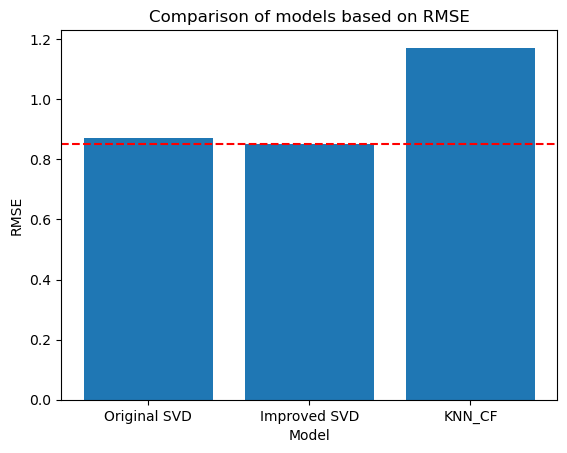

In [71]:
# comparison between original RMSE and Improved SVD RMSE

import matplotlib.pyplot as plt


# Data for the bar graph
models = ['Original SVD', 'Improved SVD', 'KNN_CF']
rmse_values = [rmse, rmse_improved,RMSE_60]

# Create the bar graph
plt.bar(models, rmse_values)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Comparison of models based on RMSE')
plt.axhline(y=min(rmse_values), color='r', linestyle='--')
plt.show()


# Task 3: Ranking-based Evaluation and Comparison

In [73]:
#IMFR recommendation

import random
from collections import defaultdict

In [74]:
# Creating a list of unique user ids and movie ids
unique_users= df['UserID'].unique().tolist()
unique_movies= df['MovieID'].unique().tolist()


In [75]:
# Finding the list of users that have rated more than 100 movies
count_users= df.groupby('UserID').size()
user_100 = count_users[count_users > 100].index.tolist()
len(user_100)

2909

In [76]:
# Set a random seed for Reproducibility 
random.seed(42)
#Randomly selecting 10 users
user_sample = random.sample(user_100,10)
user_sample

[5470, 1001, 237, 2403, 2120, 1939, 1219, 926, 5759, 4681]

In [77]:
#Recommending and calculating AP score and NDGC for IMFR

from collections import defaultdict
import pandas as pd
from sklearn.metrics import average_precision_score, ndcg_score

# Prepare results dictionary to create a dataframe
results = {'UserID': [], 'AP': [], 'NDCG': []}

# Create a list of all unique MovieIDs
all_movies = df['MovieID'].unique()

for user_id in user_sample:
    recommendations = defaultdict(list)  # Create a dictionary for recommendations
    
    # Creating predictions for all movies
    for movie_id in all_movies:
        pred_rating = IMFR.predict(user_id, movie_id)
        recommendations[user_id].append((movie_id, pred_rating))

    # Creating top 20 recommendations for each of the users
    top_20 = {}
    for user_id, rating in recommendations.items():
        sorted_movies = sorted(rating, key=lambda x: x[1], reverse=True)[:20]  # Sort based on predictions
        top_20[user_id] = sorted_movies

    # Prepare to calculate metrics
    for user_id, recs in top_20.items():
        # Get the recommended movie IDs
        recommended_movie_ids = [movie[0] for movie in recs]
        
        # Get true ratings for the current user
        true_ratings = df[df['UserID'] == user_id]['MovieID'].values
        
        # Calculate AP if there are positive instances in true ratings
        if len(true_ratings) > 0 and len(recommended_movie_ids) > 0:
            y_true_ap = [1 if movie in true_ratings else 0 for movie in recommended_movie_ids]
            # Ensure there are positive instances for AP calculation
            if sum(y_true_ap) > 0:  
                ap = average_precision_score(y_true=y_true_ap, y_score=[1]*len(recommended_movie_ids))  
            else:
                ap = 0  # No relevant items in recommended, set AP to 0
        else:
            ap = 0  # If there are no true ratings or recommended movies, set AP to 0
        
        # Calculate NDCG only if there are relevant items
        if len(true_ratings) > 0 and len(recommended_movie_ids) > 0:
            y_true_ndcg = [1 if movie in true_ratings else 0 for movie in recommended_movie_ids]
            # Calculate NDCG only if there's at least one positive instance
            if sum(y_true_ndcg) > 0:
                ndcg = ndcg_score([y_true_ndcg], [recommended_movie_ids])  # NDCG requires lists of arrays
            else:
                ndcg = 0  # No relevant items in recommended, set NDCG to 0
        else:
            ndcg = 0  # If there are no true ratings or recommended movies, set NDCG to None



        # Store results
        results['UserID'].append(user_id)
        results['AP'].append(ap)
        results['NDCG'].append(ndcg)

        for user_id, movie_recommendations in top_20.items():
            recommended_movies = [movie_id for movie_id, _ in movie_recommendations]
        
           

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Print the resulting DataFrame
print(results_df)

# Calculate overall AP and NDCG
overall_ap = results_df['AP'].mean()
overall_ndcg = results_df['NDCG'].mean()

#         # Calculate overall AP and NDCG for IMFR
# overall_ap_imfr = results_imfr_df['AP'].mean() if results_imfr_df['AP'].size > 0 else 0
# overall_ndcg_imfr = results_imfr_df['NDCG'].mean() if results_imfr_df['NDCG'].size > 0 else 0

# Print the results
print(f"Overall Average Precision (AP): {overall_ap}")
print(f"Overall NDCG: {overall_ndcg}")

   UserID    AP      NDCG
0    5470  0.00  0.000000
1    1001  0.25  1.000000
2     237  0.05  0.386853
3    2403  0.00  0.000000
4    2120  0.05  0.386853
5    1939  0.00  0.000000
6    1219  0.05  0.386853
7     926  0.10  0.850345
8    5759  0.00  0.000000
9    4681  0.00  0.000000
Overall Average Precision (AP): 0.05
Overall NDCG: 0.30109033272383795


In [78]:
#Recommending and calculating AP score and NDGC for KNN

# Prepare to calculate metrics for kNN
results_knn = {'UserID': [], 'AP': [], 'NDCG': []}

# Get unique movie IDs
movie_ids = df['MovieID'].unique()  # Get unique movie IDs from the DataFrame

# Create a mapping of movie IDs to their indices
movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

# Iterate over users in user_sample
for user_id in user_sample:
    # Get the user index from the user_sample
    user_index = user_sample.index(user_id)
    
    # Ensure the user index is within bounds
    if user_index < np_predictions_KNN_60.shape[0]:
        # Get true ratings for the current user
        true_ratings = df[df['UserID'] == user_id]['MovieID'].values
        
        # Get the predicted ratings for the current user
        predicted_ratings = np_predictions_KNN_60[user_index]  # Predicted ratings for the user
        
        # Get indices of the top N (e.g., top 20) recommended movie IDs based on predicted ratings
        top_n_indices = np.argsort(predicted_ratings)[::-1][:20]  # Get indices of top 20 predictions
        
        # Get the actual movie IDs based on the indices of top N
        recommended_movie_ids = [movie_ids[i] for i in top_n_indices if i < len(movie_ids)]

        # Calculate AP
        y_true_ap = [1 if movie in true_ratings else 0 for movie in recommended_movie_ids]
        
        # Avoid AP calculation if no positive classes exist
        if sum(y_true_ap) > 0:  # Check if there's at least one relevant item
            ap = average_precision_score(y_true=y_true_ap, y_score=[1]*len(recommended_movie_ids))  # y_score is uniform here
        else:
            ap = 0  # Set AP to 0 if no relevant items

        # Create a binary relevance score for NDCG calculation
        y_true_ndcg = [1 if movie in true_ratings else 0 for movie in recommended_movie_ids]

        # Calculate NDCG, ensuring we don't pass empty arrays
        if len(y_true_ndcg) > 0 and sum(y_true_ndcg) > 0:  # Check for positive classes
            ndcg = ndcg_score([y_true_ndcg], [recommended_movie_ids])  # NDCG requires lists of arrays
        else:
            ndcg = 0  # Set NDCG to 0 if no relevant items

        # Store results
        results_knn['UserID'].append(user_id)
        results_knn['AP'].append(ap)
        results_knn['NDCG'].append(ndcg)


# Convert results to DataFrame for easier analysis
results_knn_df = pd.DataFrame(results_knn)

# Calculate overall AP and NDCG for kNN
overall_ap_knn = results_knn_df['AP'].mean() if results_knn_df['AP'].size > 0 else 0
overall_ndcg_knn = results_knn_df['NDCG'].mean() if results_knn_df['NDCG'].size > 0 else 0

# Print the results
print("KNN Method Results:")
print(results_knn_df)
print(f"Overall Average Precision (AP) for kNN: {overall_ap_knn}")
print(f"Overall NDCG for kNN: {overall_ndcg_knn}")


KNN Method Results:
   UserID        AP      NDCG
0    5470  0.000000  0.000000
1    1001  0.052632  0.315465
2     237  0.052632  0.244651
3    2403  0.000000  0.000000
4    2120  0.105263  0.564092
5    1939  0.000000  0.000000
6    1219  0.000000  0.000000
7     926  0.000000  0.000000
8    5759  0.210526  0.634479
9    4681  0.052632  0.301030
Overall Average Precision (AP) for kNN: 0.047368421052631574
Overall NDCG for kNN: 0.2059716676973021


In [79]:
#Visualisation

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
# Create an overall results dataframe for AP and NDCG
overall_results = pd.DataFrame({
    'Method': ['kNN', 'IMFR'],
    'Overall AP': [overall_ap_knn, overall_ap],
    'Overall NDCG': [overall_ndcg_knn, overall_ndcg]
})

In [82]:
overall_results

,Method,Overall AP,Overall NDCG
0,kNN,0.047368,0.205972
1,IMFR,0.050000,0.301090


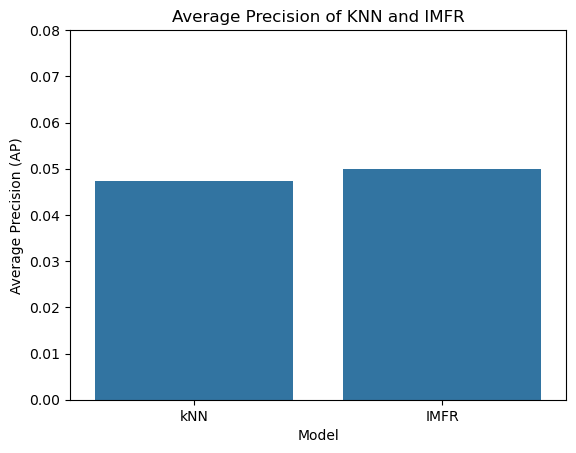

In [83]:
#Average precision chart
sns.barplot(data=overall_results, x='Method', y='Overall AP')
plt.title('Average Precision of KNN and IMFR')
plt.ylabel('Average Precision (AP)')
plt.xlabel('Model')
plt.ylim(0, 0.08) 
plt.show()


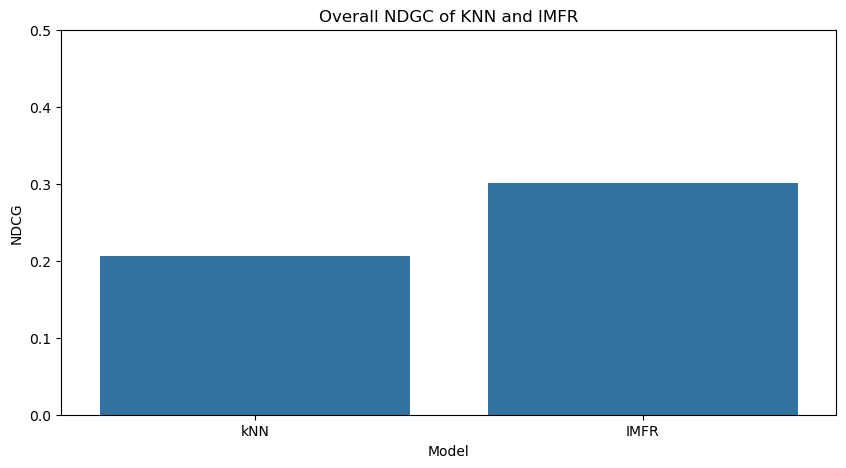

In [84]:
#Average precision chart
plt.figure(figsize=(10, 5))
sns.barplot(data=overall_results, x='Method', y='Overall NDCG')
plt.title('Overall NDGC of KNN and IMFR')
plt.ylabel('NDCG')
plt.xlabel('Model')
plt.ylim(0, 0.5)  # Assuming NDCG values are between 0 and 1
plt.show()


In [85]:
# Listing out the recommendations for each user based on IMFR

In [86]:
# Loop through each user and movie, predicting the rating
predictions_list =[]
for user_id in user_sample:
    for movie_id in all_movies:
        pred_rating = IMFR.predict(user_id, movie_id)
        # Append the result as a tuple
        predictions_list.append((user_id, movie_id, pred_rating.est))

# Create a DataFrame from the predictions list
predictions = pd.DataFrame(predictions_list, columns=['userID', 'itemID', 'prediction'])

# Display the first few rows of the predictions DataFrame
print(predictions)

       userID  itemID  prediction
0        5470    1193    4.326105
1        5470     661    3.523371
2        5470     914    3.855133
3        5470    3408    3.429508
4        5470    2355    3.762954
...       ...     ...         ...
37055    4681    2198    3.483983
37056    4681    2703    3.291888
37057    4681    2845    2.456703
37058    4681    3607    3.826397
37059    4681    2909    3.746828

[37060 rows x 3 columns]


In [87]:
# Filter the predictions for the specific user and sort by predicted rating
top_n = 20
for user_id in user_sample:
    user_recommendations = predictions[predictions['userID'] == user_id]
    top_recommendations = user_recommendations.sort_values(by='prediction', ascending=False).head(top_n)

    # Display the top recommendations for the specified user
    print(top_recommendations)

      userID  itemID  prediction
2801    5470    3245    4.665153
3266    5470    1117    4.644712
669     5470     858    4.625892
1673    5470    1147    4.624445
1288    5470    3338    4.594097
3155    5470    2931    4.593885
1638    5470    3091    4.587480
2562    5470     787    4.564148
3412    5470    2503    4.538244
611     5470     750    4.518723
236     5470    1250    4.503421
44      5470     260    4.501384
1092    5470    2019    4.499455
2617    5470    2905    4.487587
2313    5470    2937    4.471020
546     5470    1233    4.460354
662     5470     924    4.457313
1494    5470    3022    4.455894
2473    5470     668    4.455074
629     5470     904    4.450856
      userID  itemID  prediction
7118    1001    2503    4.875857
5937    1001    1178    4.840184
5628    1001    3307    4.778982
6821    1001     106    4.773258
4798    1001    2019    4.765057
4989    1001    1212    4.764788
6429    1001    2830    4.759596
6972    1001    1117    4.733465
5155    10